In [1]:
#refs
#https://www.kaggle.com/code/anatpeled/spotify-popularity-prediction

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set() # set the default Seaborn style for graphics

## Data Prep and Cleaning

In [3]:
allsongs = pd.read_csv('datasets/spotify_dataset.csv', dtype={'song_name': str})

# Cleaning dataset
allsongs = allsongs.drop(columns = ['artist', 'uri'])

# drop rows without track name
allsongs = allsongs.dropna(subset=['track'])
allsongs = allsongs.reset_index(drop=True)

# Change decade column to int
allsongs['decade'] = allsongs.decade.str.replace('s' , '')
allsongs['decade'] = pd.to_numeric(allsongs['decade'])

allsongs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
count,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000,4.109900e+04,41099.000000,41099.000000,41099.000000,41099.000000,41099.000000
mean,0.539683,0.579544,5.213752,-10.221446,0.693375,0.072952,0.364232,0.154403,0.201534,0.542450,119.336349,2.348755e+05,3.893647,40.106896,10.475632,0.499964,52.926592
std,0.177808,0.252629,3.535060,5.311227,0.461098,0.086106,0.338908,0.303518,0.172957,0.267333,29.099116,1.189696e+05,0.423072,19.006697,4.872026,0.500006,32.562016
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816500,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.395500,1.729165e+05,4.000000,27.599510,8.000000,0.000000,10.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.559000,117.564000,2.179070e+05,4.000000,35.850270,10.000000,0.000000,60.000000
75%,0.669000,0.787000,8.000000,-6.375000,1.000000,0.069800,0.676000,0.061200,0.261000,0.768000,136.492000,2.667730e+05,4.000000,47.627240,12.000000,1.000000,80.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000,90.000000


## Exploratory Data Analysis/Visualisation

In [4]:
songtraits = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "chorus_hit", "sections", "decade"]

In [5]:
# Splitting dataset into popular and non-popular songs
popular = allsongs[allsongs['popularity'] == 1]
notpopular = allsongs[allsongs['popularity'] == 0]

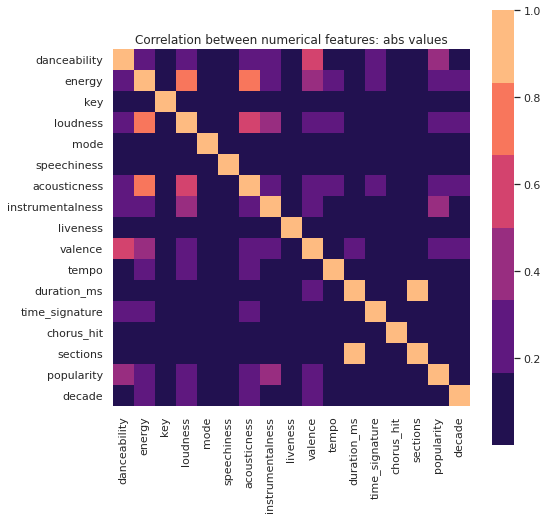

In [6]:
# Numeric Heatmap


numeric_columns = allsongs.columns[allsongs.dtypes != 'object']
numeric_df = pd.DataFrame(data=allsongs, columns=numeric_columns, index=allsongs.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sb.color_palette("magma")
sb.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [7]:
# allsongs['duration_ms'].corr(allsongs['popularity'])
series = np.abs(corr['popularity']).sort_values(ascending=False)

print('The most linearly correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.11 <= row < 1:
      print(f'{series.index[i]:18} -> {row: .3f} (abs)')

The most linearly correlated features to POPULARITY are:
instrumentalness   ->  0.408 (abs)
danceability       ->  0.346 (abs)
loudness           ->  0.286 (abs)
valence            ->  0.251 (abs)
acousticness       ->  0.246 (abs)
energy             ->  0.177 (abs)


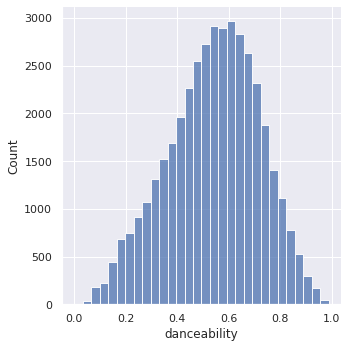

In [8]:
# Danceability

sb.displot(allsongs['danceability'], kde=False, bins=30)
plt.show()

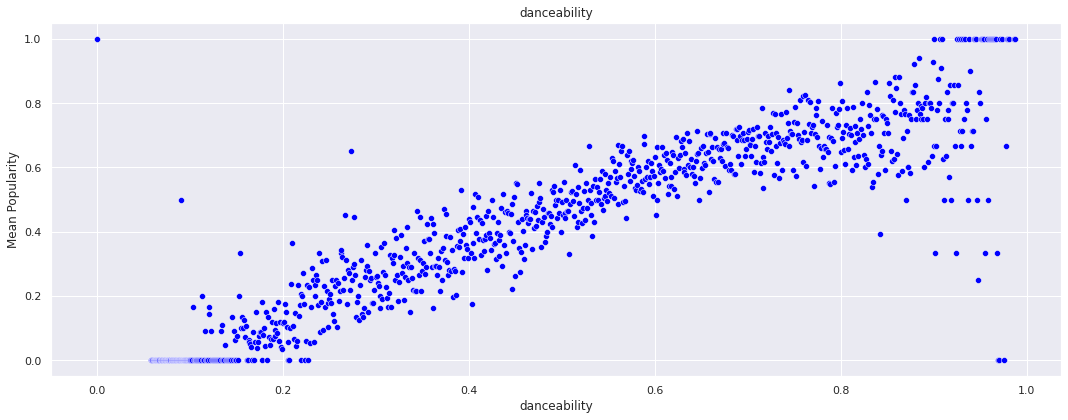

In [9]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('danceability')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='danceability', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Machine learning techniques to solve specific problem
### Problem:

,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
0,Jealous Kind Of Fella,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,60
1,Initials B.B.,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,60
2,Melody Twist,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,60
3,Mi Bomba Sonó,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,60
4,Uravu Solla,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,60


[60, 70, 80, 90, 0, 10]
